In [2]:
import pandas as pd
import numpy as  np

from TargetEncoderv3 import TargetEncoder
from FeatureSelector import FeatureSelector

from sklearn.metrics import *
from sklearn.model_selection import *

import lightgbm as lgb
from utils import outoffold_crossvalidator, shuffle_crossvalidator

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# create a file handler
handler = logging.FileHandler('LGB_featureset1.log')
handler.setLevel(logging.INFO)

# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# add the handlers to the logger
logger.addHandler(handler)
#import sys
#sys.stdout = logger



In [3]:
dtypes = {
    'ip'            : 'uint32',
    'app'           : 'uint16',
    'device'        : 'uint16',
    'os'            : 'uint16',
    'channel'       : 'uint16',
    'is_attributed' : 'uint8',
    'click_id'      : 'uint32'
    }

logger.info("Reading train file")
train = pd.read_csv("../input/train_featureset1_v2.csv", dtype=dtypes, compression='gzip')

logger.info("Reading test file")
test = pd.read_csv("../input/test_featureset1_v2.csv", dtype=dtypes, compression='gzip')


INFO:__main__:Reading train file
INFO:__main__:Reading test file


In [4]:
print(train.shape, test.shape)
print(train.describe())
print(test.describe())

(100000, 42) (18790469, 41)
                  ip           app         device             os  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean    91255.879670      12.04788      21.771250      22.818280   
std     69835.553661      14.94150     259.667767      55.943136   
min         9.000000       1.00000       0.000000       0.000000   
25%     40552.000000       3.00000       1.000000      13.000000   
50%     79827.000000      12.00000       1.000000      18.000000   
75%    118252.000000      15.00000       1.000000      19.000000   
max    364757.000000     551.00000    3867.000000     866.000000   

             channel  is_attributed      hourofday      dayofweek  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      268.832460       0.002270       9.328590       1.861460   
std       129.724248       0.047591       6.180586       0.889266   
min         3.000000       0.000000       0.000000       0.000000   
25%       145.

In [15]:
train.loc[train[['ip', 'device', 'os']].duplicated(), 'is_attributed']

0.0007147962830593281

In [4]:
print(train.dtypes)
print(test.dtypes)

ip                          uint32
app                         uint16
device                      uint16
os                          uint16
channel                     uint16
attributed_time             object
is_attributed                uint8
hourofday                    int64
dayofweek                    int64
ip_hour_channel_dayvar     float64
ip_hour_day_count            int64
ip_day_channel_hourvar     float64
ip_count                   float64
app_count                  float64
device_count               float64
os_count                   float64
channel_count              float64
hourofday_count              int64
ip_app_count               float64
app_device_count           float64
app_os_count               float64
app_channel_count          float64
app_hourofday_count        float64
device_hourofday_count     float64
os_hourofday_count         float64
channel_hourofday_count    float64
channel_os_count           float64
ip_mean                    float64
app_mean            

In [5]:
print(train.isnull().sum()/len(train))
print(test.isnull().sum()/len(test))

ip                         0.00000
app                        0.00000
device                     0.00000
os                         0.00000
channel                    0.00000
attributed_time            0.99773
is_attributed              0.00000
hourofday                  0.00000
dayofweek                  0.00000
ip_hour_channel_dayvar     0.96255
ip_hour_day_count          0.00000
ip_day_channel_hourvar     0.89123
ip_count                   0.18140
app_count                  0.00041
device_count               0.00070
os_count                   0.00024
channel_count              0.00007
hourofday_count            0.00000
ip_app_count               0.65385
app_device_count           0.00175
app_os_count               0.00623
app_channel_count          0.00075
app_hourofday_count        0.00405
device_hourofday_count     0.00139
os_hourofday_count         0.00303
channel_hourofday_count    0.00302
channel_os_count           0.01280
ip_mean                    0.18140
app_mean            

In [6]:
logger.info("Generating train and validation sets")
val_idx = np.array(train.loc[(train.dayofweek == 3) & (train.hourofday.isin([4]))].index)
tr_idx  = np.array(train.loc[~((train.dayofweek == 3) & (train.hourofday.isin([4])))].index)

print(len(tr_idx), len(val_idx))
cvlist1 = [[tr_idx, val_idx]]

model = lgb.LGBMClassifier(num_leaves=7, max_depth=3, n_jobs=-1, n_estimators=1500, subsample=1.0, 
                           colsample_bytree=0.7, min_child_samples=1000, scale_pos_weigt=100,
                       verbose=10)


INFO:__main__:Generating train and validation sets


97792 2208


In [7]:
features= ['ip', 'app','device','os','channel','ip_hour_day_count','ip_count',
           'app_count','device_count','os_count','channel_count','hourofday_count',
           'app_device_count','app_os_count','app_channel_count','app_hourofday_count',
           'device_hourofday_count','os_hourofday_count','channel_hourofday_count',
           'channel_os_count','app_mean','device_mean','os_mean','channel_mean',
           'app_device_mean','app_os_mean','app_channel_mean','app_hourofday_mean',
          'device_hourofday_mean','os_hourofday_mean','channel_hourofday_mean','channel_os_mean'
          ]

X = train[features]
y = train.is_attributed
print(X.loc[cvlist1[0][0]].shape, X.loc[cvlist1[0][1]].shape)
#print(len(cvlist1[0][0]))
logger.info("check model performance on validation set")
val_preds, y_val, _ = shuffle_crossvalidator(model, X, y, cvlist=cvlist1)
logger.info("Validation score is {}".format(roc_auc_score(y_val, val_preds)))

INFO:__main__:check model performance on validation set


(97792, 32) (2208, 32)
Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.967169	valid_1's auc: 0.976493
[20]	valid_0's auc: 0.967942	valid_1's auc: 0.983144
[30]	valid_0's auc: 0.968198	valid_1's auc: 0.987075
[40]	valid_0's auc: 0.967995	valid_1's auc: 0.979516
[50]	valid_0's auc: 0.976586	valid_1's auc: 0.98904
[60]	valid_0's auc: 0.983753	valid_1's auc: 0.991988
[70]	valid_0's auc: 0.986728	valid_1's auc: 0.990023
[80]	valid_0's auc: 0.989056	valid_1's auc: 0.993651
[90]	valid_0's auc: 0.991068	valid_1's auc: 0.996221
[100]	valid_0's auc: 0.994358	valid_1's auc: 0.995011
[110]	valid_0's auc: 0.994821	valid_1's auc: 0.994407
[120]	valid_0's auc: 0.995764	valid_1's auc: 0.993651
[130]	valid_0's auc: 0.996385	valid_1's auc: 0.992139
[140]	valid_0's auc: 0.996618	valid_1's auc: 0.991837

INFO:__main__:Validation score is 0.9962207105064248



Early stopping, best iteration is:
[90]	valid_0's auc: 0.991068	valid_1's auc: 0.996221
Score for this fold is  0.9962207105064248
Overall score on 10 fold CV is 0.9962207105064248


In [8]:
logger.info("fit model on all data and predict on test")
model = lgb.LGBMClassifier(num_leaves=7, max_depth=3, n_jobs=-1, n_estimators=100, subsample=1.0, 
                           colsample_bytree=0.7, min_child_samples=1000, scale_pos_weigt=100,
                       verbose=10)

X_test = test[features]
test_preds = model.fit(train[features], train.is_attributed, 
                       eval_set=[(train[features], train.is_attributed,)],
                       eval_metric='auc').predict_proba(X_test)[:,1]

INFO:__main__:fit model on all data and predict on test


[1]	valid_0's auc: 0.94295
[2]	valid_0's auc: 0.957456
[3]	valid_0's auc: 0.96742
[4]	valid_0's auc: 0.967358
[5]	valid_0's auc: 0.967422
[6]	valid_0's auc: 0.967422
[7]	valid_0's auc: 0.968345
[8]	valid_0's auc: 0.968024
[9]	valid_0's auc: 0.967881
[10]	valid_0's auc: 0.967903
[11]	valid_0's auc: 0.967821
[12]	valid_0's auc: 0.968092
[13]	valid_0's auc: 0.968237
[14]	valid_0's auc: 0.968179
[15]	valid_0's auc: 0.968183
[16]	valid_0's auc: 0.968172
[17]	valid_0's auc: 0.968245
[18]	valid_0's auc: 0.968126
[19]	valid_0's auc: 0.968127
[20]	valid_0's auc: 0.968159
[21]	valid_0's auc: 0.968175
[22]	valid_0's auc: 0.968127
[23]	valid_0's auc: 0.968156
[24]	valid_0's auc: 0.96807
[25]	valid_0's auc: 0.968378
[26]	valid_0's auc: 0.968157
[27]	valid_0's auc: 0.967606
[28]	valid_0's auc: 0.967893
[29]	valid_0's auc: 0.967846
[30]	valid_0's auc: 0.967813
[31]	valid_0's auc: 0.967812
[32]	valid_0's auc: 0.967843
[33]	valid_0's auc: 0.967879
[34]	valid_0's auc: 0.967424
[35]	valid_0's auc: 0.9674

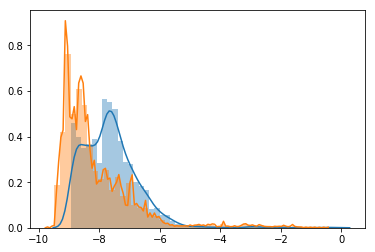

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(np.log(val_preds))
sns.distplot(np.log(test_preds))
#plt.savefig("./distributions.png")
plt.show()

In [11]:
display(val_preds[:5])
display(test_preds[:5])

array([0.00022676, 0.00024416, 0.00013985, 0.00041839, 0.00049671])

array([0.00078003, 0.00167295, 0.00018704, 0.00054284, 0.00016886])

In [ ]:
logger.info("Write out submission")
sub = pd.DataFrame()
sub['click_id'] = test['click_id']
sub['is_attributed'] = test_preds
logger.info(sub['is_attributed'].describe())
logger.info(sub.head())

sub.to_csv("../input/first_submission_corr.csv", index=False)
    
